In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
from statistics import median, mean
from multiprocessing import Process
import requests
from multiprocessing.pool import ThreadPool as Pool
import timeit

## Practice using python statistics on Dataframe Rows

In [3]:
df = pd.DataFrame(np.random.randn(1000,100)) #row, columns

In [4]:
print(median(df[0]))
print(mean(df[0]))
print(max(df[0]))
print(min(df[0]))

#plt.table(cellText=df.values, colLabels=df.columns, loc='center')
#df.describe()

-0.03582519026860897
0.008740473568725456
3.6489496682668277
-3.0508842183301015


## Function that gets maximum from all medians of rows in a 'chunk'

In [5]:
def chunkMax(chunk) -> float:
    if (len(chunk) == 0):
        print("error: chunk row count == 0")
        return
    
    chunkMax = median(chunk.iloc[0])
    
    for i in range(1, len(chunk)) :
        med = median(chunk.iloc[i])
        if (chunkMax < med):
            chunkMax = med
    return chunkMax

In [6]:
dfMax = chunkMax(df)
print(dfMax)

0.432178896463803


## Practice splitting a python dataframe

In [7]:
df1 = df.iloc[:500,:]
df2 = df.iloc[500:,:]

In [8]:
df1Max = chunkMax(df1)
df2Max = chunkMax(df2)
print(df1Max)
print(df2Max)

0.376557792683876
0.432178896463803


## Function to split dataframe into certain number of chunks

There may be a better way to do this, but I haven't found out how

In [9]:
def splitdf(df, numSplit):
    size = int(len(df) / numSplit)
    splitArray = []
    for i in range(0, numSplit - 1) :
        splitArray.append(df.iloc[size*i:size*i+1])
    splitArray.append(df.iloc[size*(numSplit-1):size*numSplit])
    return splitArray

In [10]:
chunks = splitdf(df, 3)


pool = Pool(10)
chunkMaxes = []
for result in pool.imap_unordered(chunkMax, chunks):
    chunkMaxes.append(result)

print("this is the gobal maximum of all medians:")
print(max(chunkMaxes))


this is the gobal maximum of all medians:
0.432178896463803


## Practicing using timeit python module

In [11]:
t_0 = timeit.default_timer()
# call function
res = chunkMax(df)
# record end time
t_1 = timeit.default_timer()

et_1 = round((t_1 - t_0) * 10 ** 6, 3) / 1000000
print(f"Elapsed time: {et_1} ms")

Elapsed time: 0.1452948 ms


In [12]:
t_0 = timeit.default_timer()
# call function
chunks = splitdf(df, 3)
pool = Pool(10)
chunkMaxes = []
for result in pool.imap_unordered(chunkMax, chunks):
    chunkMaxes.append(result)
# record end time
t_1 = timeit.default_timer()

et_3 = round((t_1 - t_0) * 10 ** 6, 3) / 1000000
print(f"Elapsed time: {et_3 } ms")

Elapsed time: 0.058806199999999996 ms


In [14]:
t_0 = timeit.default_timer()
# call function
chunks = splitdf(df, 12)
pool = Pool(10)
chunkMaxes = []
for result in pool.imap_unordered(chunkMax, chunks):
    chunkMaxes.append(result)
# record end time
t_1 = timeit.default_timer()

et_12 = round((t_1 - t_0) * 10 ** 6, 3) / 1000000
print(f"Elapsed time: {et_12} ms")

Elapsed time: 0.0215792 ms


## Pretty Outputs

[0.1176195, 0.053497, 0.0271866, 0.0204305, 0.0164846, 0.014130299999999998, 0.0123653, 0.0118973, 0.0110773, 0.0105141, 0.0102032, 0.009808]


Text(0, 0.5, 'Run Time (ms)')

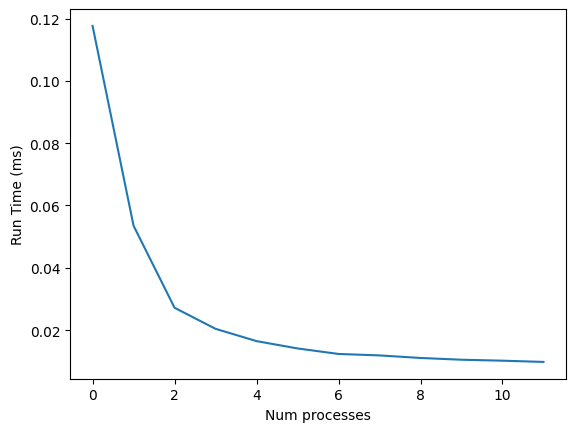

In [29]:
maxProcesses = 12
processNums = list(range(0, maxProcesses)) #my computer has 12 cores, just doing 200 for the heck of it
times = []

t_0 = timeit.default_timer()
# call function
res = chunkMax(df)
# record end time
t_1 = timeit.default_timer()

times.append(round((t_1 - t_0) * 10 ** 6, 3) / 1000000)

for i in processNums:
    if i == 0:
        continue
    t_0 = timeit.default_timer()
    # call function
    chunks = splitdf(df, i)
    pool = Pool(i)
    chunkMaxes = []
    for result in pool.imap_unordered(chunkMax, chunks):
        chunkMaxes.append(result)
    # record end time
    t_1 = timeit.default_timer()

    times.append(round((t_1 - t_0) * 10 ** 6, 3) / 1000000)

print(times)

plt.plot(processNums, times)
plt.xlabel('Num processes')#, fontweight='bold', color = 'orange', fontsize='17', horizontalalignment='center')
plt.ylabel('Run Time (ms)')